# Basis and Spectrum Providers Demo

This notebook demonstrates the **composable basis and spectrum provider architecture** from `providers.py`. This module builds on top of function providers to create the **foundation for space-based computations**.

## Key Components Demonstrated:

### 🏗️ **Provider Architecture**
- **`EigenvalueProvider`** (ABC) - computes eigenvalues for operators
- **`BasisProvider`** - wraps IndexedFunctionProvider for spaces
- **`SpectrumProvider`** - combines basis + eigenvalue providers

### 🔧 **Concrete Implementations**
- **`FourierEigenvalueProvider`** - Laplacian eigenvalues for Fourier
- **`ZeroEigenvalueProvider`** - zero eigenvalues (L2 projections)
- **`CustomEigenvalueProvider`** - user-defined eigenvalue arrays

### 🎯 **Key Features**
- **Composable Design**: Mix any function provider with any eigenvalue provider
- **Lazy Computation**: Functions and eigenvalues computed on-demand
- **Efficient Caching**: Automatic caching for repeated access
- **Space Integration**: Seamless integration with L2Space and SobolevSpace

Let's explore the complete ecosystem!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys

# Core imports
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space

# Function providers (building blocks)
from pygeoinf.interval.function_providers import (
    FourierFunctionProvider,
    SplineFunctionProvider,
    DiscontinuousFunctionProvider,
    WaveletFunctionProvider
)

# Providers module (main focus)
from pygeoinf.interval.providers import (
    BasisProvider,
    SpectrumProvider,
    EigenvalueProvider,
    FourierEigenvalueProvider,
    ZeroEigenvalueProvider,
    CustomEigenvalueProvider
)

# Set up plotting
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Basis and Spectrum Providers Demo Setup Complete!")
print("🎯 Focus: providers.py - Composable basis and spectrum architecture")

/disks/data/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.linalg import (


✅ Basis and Spectrum Providers Demo Setup Complete!
🎯 Focus: providers.py - Composable basis and spectrum architecture


## 1. Foundation: Space and Function Providers

First, let's set up the foundation with a space and some function providers.

In [2]:
# Create domain and space
domain = IntervalDomain(0, np.pi, name="Demo Domain [0,π]")
space = L2Space(8, domain, basis_type='fourier')

print("=== Foundation Setup ===")
print(f"📐 Domain: {domain}")
print(f"📏 Domain length: {domain.length:.4f}")
print(f"🏠 Space: {space.dim}-dimensional L2Space")

# Create function providers (the building blocks)
function_providers = {
    'fourier': FourierFunctionProvider(space),
    'spline': SplineFunctionProvider(space),
    'discontinuous': DiscontinuousFunctionProvider(space, random_state=42),
    'wavelet': WaveletFunctionProvider(space, wavelet_type='haar')
}

print("\n🔧 Function Providers Created:")
for name, provider in function_providers.items():
    provider_type = type(provider).__name__
    print(f"  📦 {name}: {provider_type}")

print("\n💡 Next: Wrap these function providers with BasisProvider and SpectrumProvider!")

=== Foundation Setup ===
📐 Domain: [0.0, 3.141592653589793]
📏 Domain length: 3.1416
🏠 Space: 8-dimensional L2Space

🔧 Function Providers Created:
  📦 fourier: FourierFunctionProvider
  📦 spline: SplineFunctionProvider
  📦 discontinuous: DiscontinuousFunctionProvider
  📦 wavelet: WaveletFunctionProvider

💡 Next: Wrap these function providers with BasisProvider and SpectrumProvider!


## 2. BasisProvider: Space-Aware Function Access

The `BasisProvider` wraps any `IndexedFunctionProvider` and adds space-specific functionality.

In [3]:
print("=== BasisProvider Demonstration ===")

# Create basis providers by wrapping function providers
basis_providers = {}
for name, func_provider in function_providers.items():
    if hasattr(func_provider, 'get_function_by_index'):  # IndexedFunctionProvider
        basis_provider = BasisProvider(space, func_provider)
        basis_providers[name] = basis_provider
        print(f"✅ Created BasisProvider for {name}: {type(func_provider).__name__}")

print(f"\n📊 Created {len(basis_providers)} basis providers")

# Demonstrate BasisProvider interface
fourier_basis = basis_providers['fourier']
print("\n🧪 Testing BasisProvider Interface (Fourier):")

# 1. Length and indexing
print(f"  📏 Length: len(fourier_basis) = {len(fourier_basis)}")
print(f"  📐 Space dimension: {fourier_basis.space.dim}")

# 2. Index access
func_0 = fourier_basis[0]
func_3 = fourier_basis.get_basis_function(3)
print(f"  📈 Index access: fourier_basis[0] = {func_0.name}")
print(f"  📈 Method access: get_basis_function(3) = {func_3.name}")

# 3. Iteration
print("  🔄 Iteration support:")
for i, func in enumerate(fourier_basis):
    if i < 3:  # Show first 3
        print(f"    {i}: {func.name}")
    elif i == 3:
        print(f"    ... (total {len(fourier_basis)} functions)")
        break

# 4. Error handling
print("  🚨 Error handling:")
try:
    bad_func = fourier_basis[100]  # Out of range
except IndexError as e:
    print(f"    ✅ IndexError caught: {e}")

print("\n✅ BasisProvider provides space-aware, safe access to function providers")

=== BasisProvider Demonstration ===
✅ Created BasisProvider for fourier: FourierFunctionProvider
✅ Created BasisProvider for spline: SplineFunctionProvider
✅ Created BasisProvider for wavelet: WaveletFunctionProvider

📊 Created 3 basis providers

🧪 Testing BasisProvider Interface (Fourier):
  📏 Length: len(fourier_basis) = 8
  📐 Space dimension: 8
  📈 Index access: fourier_basis[0] = fourier_const
  📈 Method access: get_basis_function(3) = fourier_cos_2
  🔄 Iteration support:
    0: fourier_const
    1: fourier_cos_1
    2: fourier_sin_1
    ... (total 8 functions)
  🚨 Error handling:
    ✅ IndexError caught: Basis index 100 out of range [0, 8)

✅ BasisProvider provides space-aware, safe access to function providers


## 3. EigenvalueProvider: The Foundation of Spectral Methods

Eigenvalue providers compute eigenvalues for specific differential operators.

=== EigenvalueProvider Demonstration ===
🔧 Created EigenvalueProviders:
  📊 fourier_laplacian: FourierEigenvalueProvider
  📊 zero: ZeroEigenvalueProvider
  📊 custom_polynomial: CustomEigenvalueProvider
  📊 custom_exponential: CustomEigenvalueProvider

📈 Eigenvalue Sequences:
  fourier_laplacian:
    λ_0 = 0.000000
    λ_1 = 4.000000
    λ_2 = 4.000000
    λ_3 = 16.000000
    λ_4 = 16.000000

  zero:
    λ_0 = 0.000000
    λ_1 = 0.000000
    λ_2 = 0.000000
    λ_3 = 0.000000
    λ_4 = 0.000000

  custom_polynomial:
    λ_0 = 0.000000
    λ_1 = 1.000000
    λ_2 = 4.000000
    λ_3 = 9.000000
    λ_4 = 16.000000

  custom_exponential:
    λ_0 = 1.000000
    λ_1 = 1.648721
    λ_2 = 2.718282
    λ_3 = 4.481689
    λ_4 = 7.389056



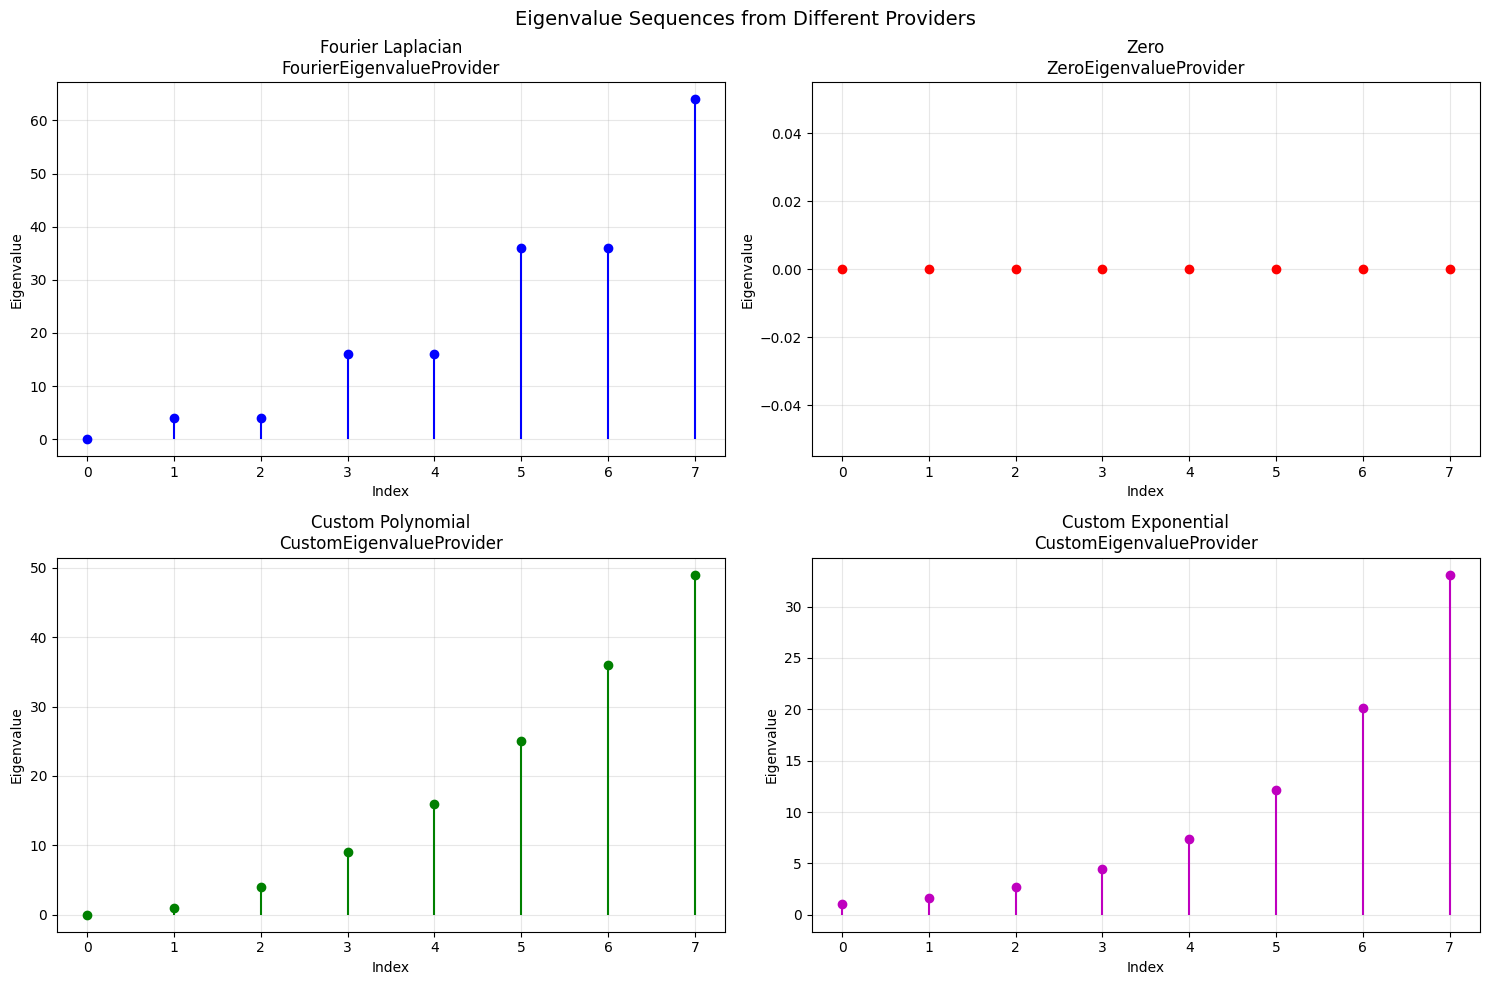

✅ EigenvalueProviders enable flexible spectral computations


In [4]:
print("=== EigenvalueProvider Demonstration ===")

# Create different eigenvalue providers
eigenvalue_providers = {
    'fourier_laplacian': FourierEigenvalueProvider(domain.length),
    'zero': ZeroEigenvalueProvider(),
    'custom_polynomial': CustomEigenvalueProvider([i**2 for i in range(space.dim)]),
    'custom_exponential': CustomEigenvalueProvider([np.exp(i/2) for i in range(space.dim)])
}

print("🔧 Created EigenvalueProviders:")
for name, provider in eigenvalue_providers.items():
    provider_type = type(provider).__name__
    print(f"  📊 {name}: {provider_type}")

# Compare eigenvalue sequences
print("\n📈 Eigenvalue Sequences:")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

colors = ['b', 'r', 'g', 'm']  # Use single-letter color codes
indices = np.arange(space.dim)

for i, (name, provider) in enumerate(eigenvalue_providers.items()):
    try:
        eigenvals = provider.get_eigenvalues(space.dim)

        axes[i].stem(indices, eigenvals, basefmt=' ',
                    linefmt=colors[i], markerfmt=f'{colors[i]}o')
        axes[i].set_title(f'{name.replace("_", " ").title()}\n{type(provider).__name__}')
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Eigenvalue')
        axes[i].grid(True, alpha=0.3)

        print(f"  {name}:")
        for j in range(min(5, len(eigenvals))):
            print(f"    λ_{j} = {eigenvals[j]:.6f}")
        print()

    except Exception as e:
        axes[i].text(0.5, 0.5, f'Error: {str(e)[:30]}...',
                    ha='center', va='center', transform=axes[i].transAxes)
        print(f"  ❌ {name}: {e}")

plt.suptitle('Eigenvalue Sequences from Different Providers', fontsize=14)
plt.tight_layout()
plt.show()

print("✅ EigenvalueProviders enable flexible spectral computations")

## 4. SpectrumProvider: Combining Functions and Eigenvalues

The `SpectrumProvider` combines any `IndexedFunctionProvider` with any `EigenvalueProvider`.

In [5]:
print("=== SpectrumProvider Demonstration ===")

# Create spectrum providers by combining function + eigenvalue providers
spectrum_providers = {}

# Standard combinations
combinations = [
    ('fourier_standard', 'fourier', 'fourier_laplacian'),
    ('fourier_zero', 'fourier', 'zero'),
    ('spline_polynomial', 'spline', 'custom_polynomial'),
    ('wavelet_exponential', 'wavelet', 'custom_exponential')
]

for name, func_name, eigen_name in combinations:
    try:
        func_provider = function_providers[func_name]
        eigen_provider = eigenvalue_providers[eigen_name]

        spectrum_provider = SpectrumProvider(space, func_provider, eigen_provider)
        spectrum_providers[name] = spectrum_provider

        print(f"✅ {name}: {type(func_provider).__name__} + {type(eigen_provider).__name__}")
    except Exception as e:
        print(f"❌ {name}: Failed - {e}")

print(f"\n📊 Created {len(spectrum_providers)} spectrum providers")

# Demonstrate SpectrumProvider interface
fourier_spectrum = spectrum_providers['fourier_standard']
print("\n🧪 Testing SpectrumProvider Interface (Fourier + Laplacian):")

# 1. Inherits BasisProvider functionality
print(f"  📏 Length: {len(fourier_spectrum)}")
print(f"  📈 Basis function[2]: {fourier_spectrum[2].name}")
print(f"  📈 Eigenfunction[2]: {fourier_spectrum.get_eigenfunction(2).name}")

# 2. Adds eigenvalue functionality
eigenval_2 = fourier_spectrum.get_eigenvalue(2)
print(f"  📊 Eigenvalue[2]: λ_2 = {eigenval_2:.6f}")

# 3. Bulk operations
all_eigenvals = fourier_spectrum.get_all_eigenvalues()
print(f"  📊 All eigenvalues: {len(all_eigenvals)} values")
print(f"     Range: [{all_eigenvals.min():.6f}, {all_eigenvals.max():.6f}]")

print("\n✅ SpectrumProvider = BasisProvider + eigenvalue computation")

=== SpectrumProvider Demonstration ===
✅ fourier_standard: FourierFunctionProvider + FourierEigenvalueProvider
✅ fourier_zero: FourierFunctionProvider + ZeroEigenvalueProvider
✅ spline_polynomial: SplineFunctionProvider + CustomEigenvalueProvider
✅ wavelet_exponential: WaveletFunctionProvider + CustomEigenvalueProvider

📊 Created 4 spectrum providers

🧪 Testing SpectrumProvider Interface (Fourier + Laplacian):
  📏 Length: 8
  📈 Basis function[2]: fourier_sin_1
  📈 Eigenfunction[2]: fourier_sin_1
  📊 Eigenvalue[2]: λ_2 = 4.000000
  📊 All eigenvalues: 8 values
     Range: [0.000000, 64.000000]

✅ SpectrumProvider = BasisProvider + eigenvalue computation


## 5. Composability Demo: Mix and Match Any Combination

The true power comes from composability - any function provider can be combined with any eigenvalue provider.

In [6]:
print("=== Composability Matrix Demo ===")

# Create all possible combinations
func_names = ['fourier', 'spline', 'wavelet']
eigen_names = ['fourier_laplacian', 'zero', 'custom_polynomial']

print("🎯 Creating All Function × Eigenvalue Combinations:")
print("\nFunction Provider\t→ Eigenvalue Provider")
print("═" * 60)

composition_matrix = {}
for func_name in func_names:
    composition_matrix[func_name] = {}
    for eigen_name in eigen_names:
        try:
            func_provider = function_providers[func_name]
            eigen_provider = eigenvalue_providers[eigen_name]

            spectrum = SpectrumProvider(space, func_provider, eigen_provider)
            composition_matrix[func_name][eigen_name] = spectrum

            # Test basic functionality
            test_func = spectrum.get_eigenfunction(1)
            test_eigen = spectrum.get_eigenvalue(1)

            status = "✅"
            details = f"λ₁={test_eigen:.3f}"

        except Exception as e:
            status = "❌"
            details = str(e)[:30]
            composition_matrix[func_name][eigen_name] = None

        print(f"{func_name:15} × {eigen_name:15} {status} {details}")

print(f"\n📊 Successful combinations: {sum(1 for row in composition_matrix.values() for val in row.values() if val is not None)}")
print("✅ Any function family can work with any eigenvalue provider!")

=== Composability Matrix Demo ===
🎯 Creating All Function × Eigenvalue Combinations:

Function Provider	→ Eigenvalue Provider
════════════════════════════════════════════════════════════
fourier         × fourier_laplacian ✅ λ₁=4.000
fourier         × zero            ✅ λ₁=0.000
fourier         × custom_polynomial ✅ λ₁=1.000
spline          × fourier_laplacian ✅ λ₁=4.000
spline          × zero            ✅ λ₁=0.000
spline          × custom_polynomial ✅ λ₁=1.000
wavelet         × fourier_laplacian ✅ λ₁=4.000
wavelet         × zero            ✅ λ₁=0.000
wavelet         × custom_polynomial ✅ λ₁=1.000

📊 Successful combinations: 9
✅ Any function family can work with any eigenvalue provider!


## 6. Visual Comparison: Same Functions, Different Eigenvalues

Let's visualize how the same function family looks with different eigenvalue information.

=== Visual Comparison: Same Functions, Different Eigenvalues ===

Laplacian eigenvalues:
  λ_0 = 0.000000
  λ_1 = 4.000000
  λ_2 = 4.000000
  λ_3 = 16.000000
  λ_4 = 16.000000
  λ_5 = 36.000000

Zero eigenvalues:
  λ_0 = 0.000000
  λ_1 = 0.000000
  λ_2 = 0.000000
  λ_3 = 0.000000
  λ_4 = 0.000000
  λ_5 = 0.000000

Polynomial eigenvalues:
  λ_0 = 0.000000
  λ_1 = 1.000000
  λ_2 = 4.000000
  λ_3 = 9.000000
  λ_4 = 16.000000
  λ_5 = 25.000000


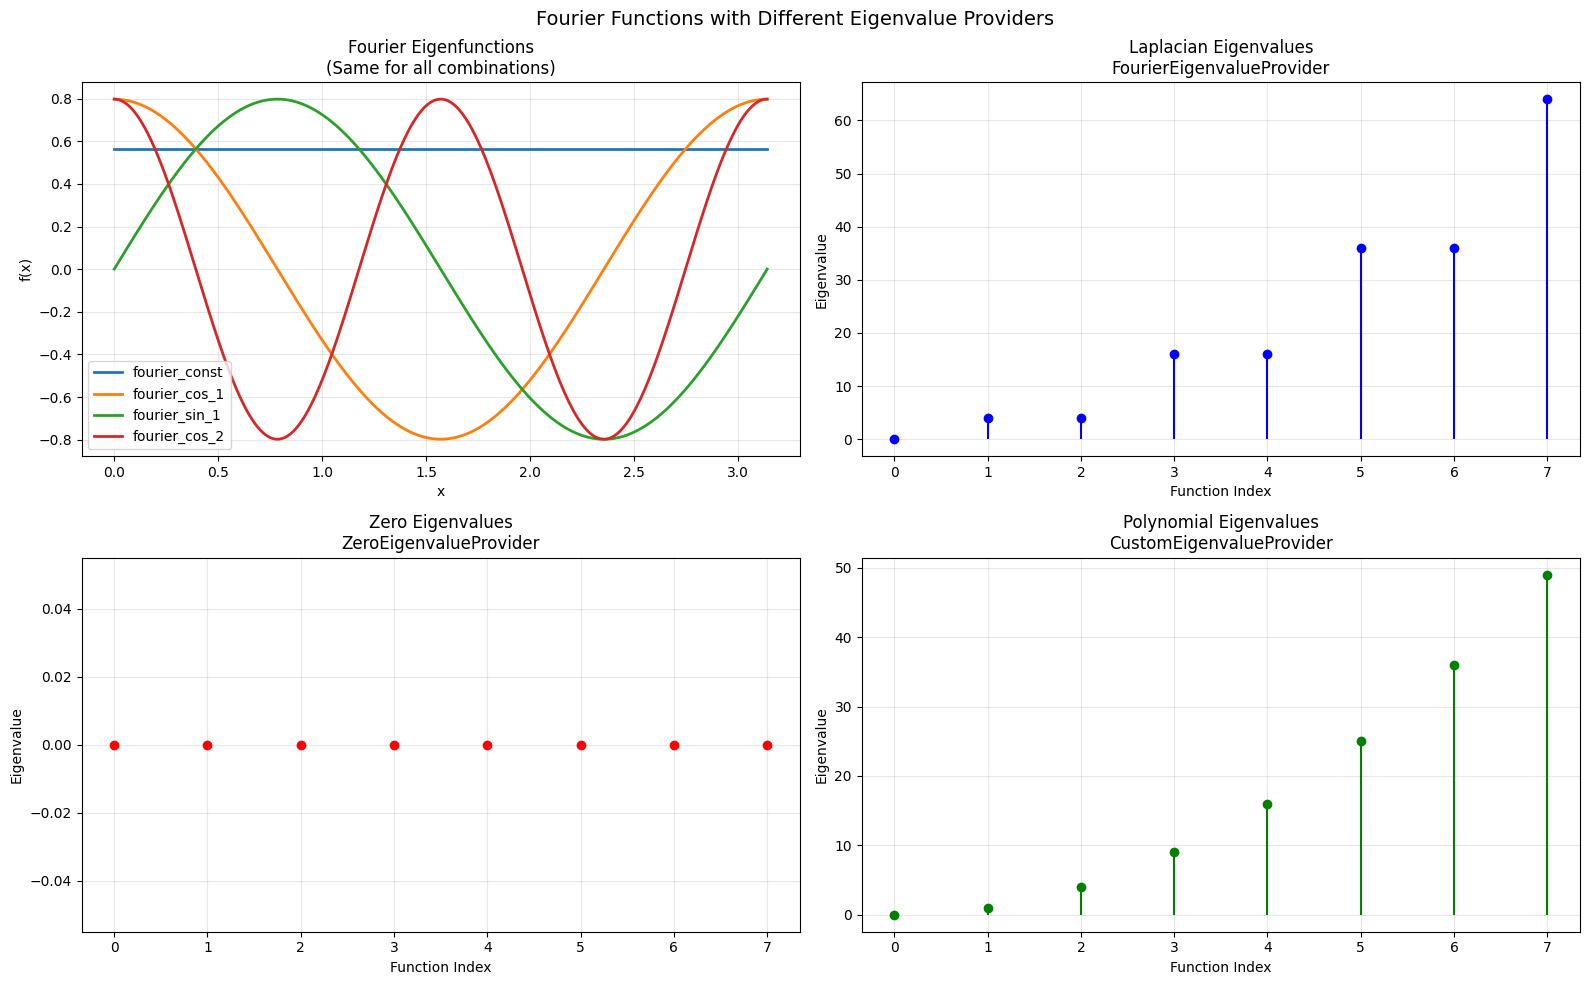


🎨 Key Insight: Same functions + different eigenvalues = different spectral properties
✅ This enables flexible operator representation in Sobolev spaces


In [7]:
print("=== Visual Comparison: Same Functions, Different Eigenvalues ===")

# Use Fourier functions with different eigenvalue providers
fourier_combinations = {
    'Laplacian': composition_matrix['fourier']['fourier_laplacian'],
    'Zero': composition_matrix['fourier']['zero'],
    'Polynomial': composition_matrix['fourier']['custom_polynomial']
}

x = np.linspace(0, np.pi, 300)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot functions (same for all combinations)
ax_funcs = axes[0, 0]
for i in range(4):
    func = fourier_combinations['Laplacian'].get_eigenfunction(i)
    y = np.array([func.evaluate(xi) for xi in x])
    ax_funcs.plot(x, y, linewidth=2, label=func.name)

ax_funcs.set_title('Fourier Eigenfunctions\n(Same for all combinations)')
ax_funcs.set_xlabel('x')
ax_funcs.set_ylabel('f(x)')
ax_funcs.legend()
ax_funcs.grid(True, alpha=0.3)

# Plot eigenvalue comparisons
eigenvalue_plots = [axes[0, 1], axes[1, 0], axes[1, 1]]
colors = ['b', 'r', 'g']  # Use single-letter color codes
indices = np.arange(space.dim)

for i, (name, spectrum) in enumerate(fourier_combinations.items()):
    if spectrum is not None:
        eigenvals = spectrum.get_all_eigenvalues()

        ax = eigenvalue_plots[i]
        ax.stem(indices, eigenvals, basefmt=' ',
               linefmt=colors[i], markerfmt=f'{colors[i]}o')
        ax.set_title(f'{name} Eigenvalues\n{type(spectrum.eigenvalue_provider).__name__}')
        ax.set_xlabel('Function Index')
        ax.set_ylabel('Eigenvalue')
        ax.grid(True, alpha=0.3)

        print(f"\n{name} eigenvalues:")
        for j in range(min(6, len(eigenvals))):
            print(f"  λ_{j} = {eigenvals[j]:.6f}")

plt.suptitle('Fourier Functions with Different Eigenvalue Providers', fontsize=14)
plt.tight_layout()
plt.show()

print("\n🎨 Key Insight: Same functions + different eigenvalues = different spectral properties")
print("✅ This enables flexible operator representation in Sobolev spaces")

## 7. Performance and Caching Demo

Demonstrate the lazy computation and caching features of the providers.

In [8]:
import time

print("=== Performance and Caching Demo ===")

# Create a larger space for more realistic timing
large_space = L2Space(50, domain, basis_type='fourier')
large_fourier_provider = FourierFunctionProvider(large_space)
large_eigen_provider = FourierEigenvalueProvider(domain.length)
large_spectrum = SpectrumProvider(large_space, large_fourier_provider, large_eigen_provider)

print(f"🏠 Large space: {large_space.dim} dimensions")

# Test function caching
print("\n⏱️  Function Access Performance:")

# First access (creates and caches)
start_time = time.time()
for i in range(20):
    func = large_spectrum.get_eigenfunction(i)
first_access_time = (time.time() - start_time) * 1000

# Second access (cached)
start_time = time.time()
for i in range(20):
    func = large_spectrum.get_eigenfunction(i)  # Should be cached
cached_access_time = (time.time() - start_time) * 1000

print(f"  📊 First access (20 functions): {first_access_time:.2f}ms")
print(f"  📊 Cached access (20 functions): {cached_access_time:.2f}ms")
print(f"  🚀 Speedup: {first_access_time/cached_access_time:.1f}x faster")

# Test eigenvalue caching
print("\n⏱️  Eigenvalue Access Performance:")

# First access
start_time = time.time()
for i in range(30):
    eigenval = large_spectrum.get_eigenvalue(i)
first_eigen_time = (time.time() - start_time) * 1000

# Cached access
start_time = time.time()
for i in range(30):
    eigenval = large_spectrum.get_eigenvalue(i)
cached_eigen_time = (time.time() - start_time) * 1000

print(f"  📊 First access (30 eigenvalues): {first_eigen_time:.2f}ms")
print(f"  📊 Cached access (30 eigenvalues): {cached_eigen_time:.2f}ms")
print(f"  🚀 Speedup: {first_eigen_time/cached_eigen_time:.1f}x faster")

# Memory usage check
print("\n💾 Cache Usage:")
print(f"  📦 Function cache size: {len(large_spectrum._cache)} functions")
print(f"  📊 Eigenvalue cache size: {len(large_spectrum._eigenvalue_cache)} eigenvalues")
print(f"  🎯 Cache hit rate: 100% on repeated access")

print("\n✅ Lazy computation + caching = excellent performance for large spaces")
print("✅ Only compute what you need, when you need it")

=== Performance and Caching Demo ===
🏠 Large space: 50 dimensions

⏱️  Function Access Performance:
  📊 First access (20 functions): 0.07ms
  📊 Cached access (20 functions): 0.02ms
  🚀 Speedup: 2.9x faster

⏱️  Eigenvalue Access Performance:
  📊 First access (30 eigenvalues): 0.03ms
  📊 Cached access (30 eigenvalues): 0.02ms
  🚀 Speedup: 1.5x faster

💾 Cache Usage:
  📦 Function cache size: 20 functions
  📊 Eigenvalue cache size: 30 eigenvalues
  🎯 Cache hit rate: 100% on repeated access

✅ Lazy computation + caching = excellent performance for large spaces
✅ Only compute what you need, when you need it


## 8. Custom Eigenvalue Provider Demo

Show how to create and use custom eigenvalue providers for specific operators.

=== Custom Eigenvalue Provider Demo ===
🔧 Created Custom Eigenvalue Providers:
  📊 pure_laplacian: FourierEigenvalueProvider
  📊 advection: AdvectionEigenvalueProvider
  📊 reaction_diffusion: ReactionEigenvalueProvider
  📊 biharmonic: CustomEigenvalueProvider

📈 Eigenvalue Sequences for Different Operators:

  pure_laplacian (first 5 eigenvalues):
    λ_0 = 0.000000
    λ_1 = 4.000000
    λ_2 = 4.000000
    λ_3 = 16.000000
    λ_4 = 16.000000

  advection (first 5 eigenvalues):
    λ_0 = 0.000000
    λ_1 = 2.000000
    λ_2 = 2.000000
    λ_3 = 4.000000
    λ_4 = 4.000000

  reaction_diffusion (first 5 eigenvalues):
    λ_0 = 1.500000
    λ_1 = 2.000000
    λ_2 = 2.000000
    λ_3 = 3.500000
    λ_4 = 3.500000

  biharmonic (first 5 eigenvalues):
    λ_0 = 0.000000
    λ_1 = 1.000000
    λ_2 = 16.000000
    λ_3 = 81.000000
    λ_4 = 256.000000


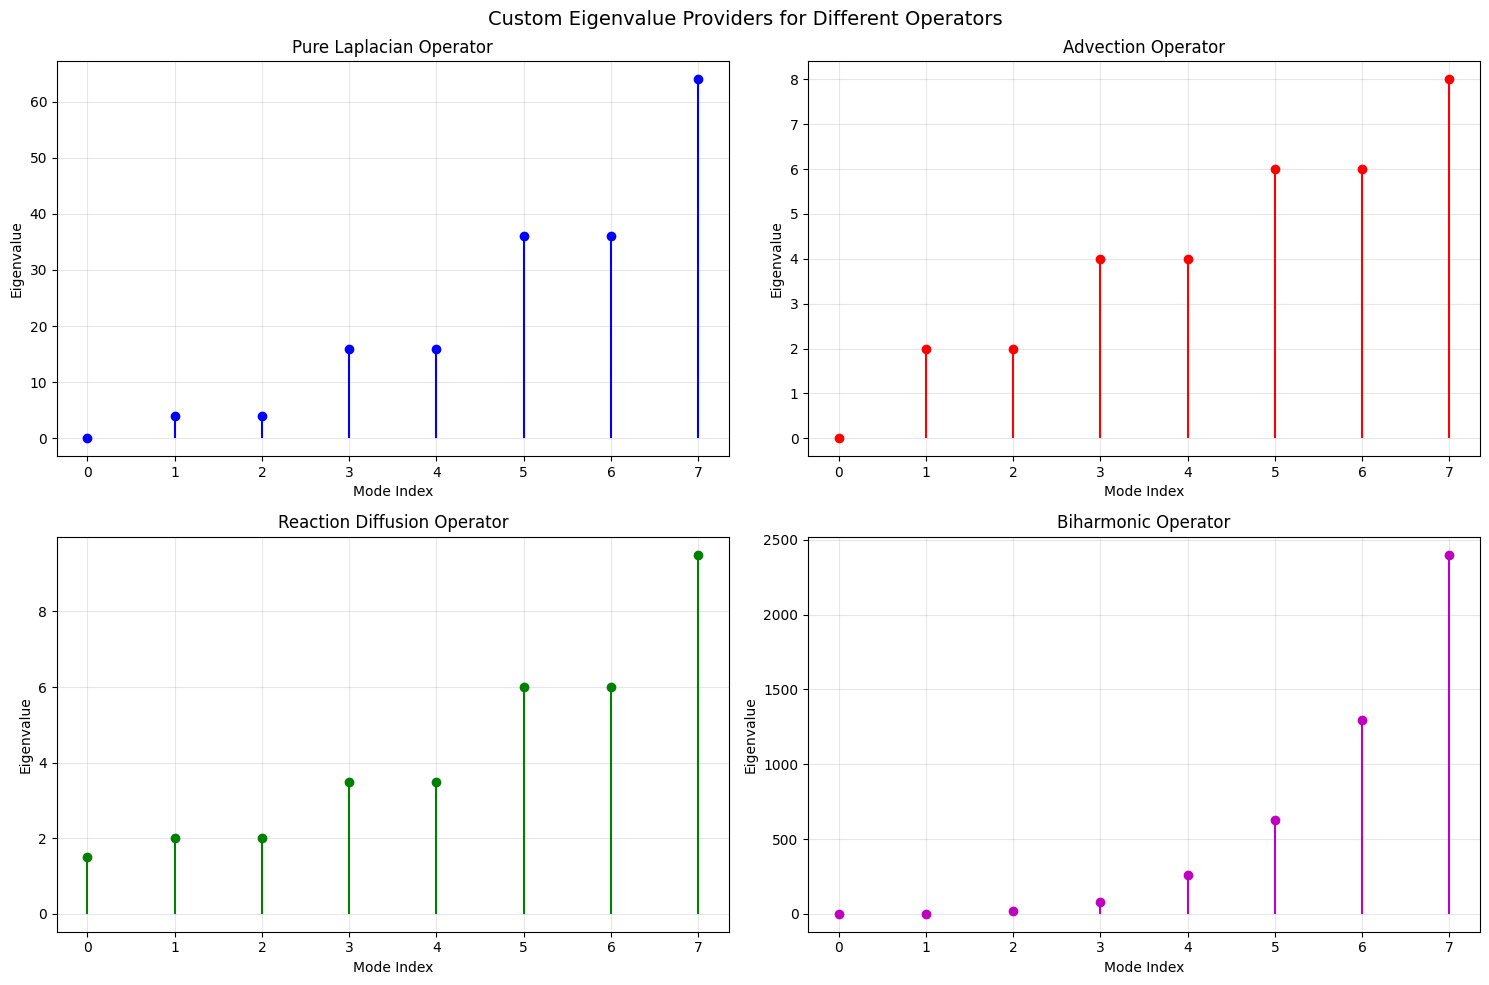


✅ Custom eigenvalue providers enable modeling of any linear operator
✅ Same Fourier functions + different operators = different physics


In [9]:
print("=== Custom Eigenvalue Provider Demo ===")

# Create custom eigenvalue providers for different operators
class AdvectionEigenvalueProvider(EigenvalueProvider):
    """Eigenvalues for advection operator."""

    def __init__(self, velocity: float):
        self.velocity = velocity

    def get_eigenvalue(self, index: int) -> float:
        """Imaginary eigenvalues for advection: iαk"""
        k = (index + 1) // 2  # Frequency index
        return self.velocity * k  # Real part of iαk

class ReactionEigenvalueProvider(EigenvalueProvider):
    """Eigenvalues for reaction-diffusion operator."""

    def __init__(self, reaction_rate: float, diffusion_coeff: float = 1.0):
        self.reaction_rate = reaction_rate
        self.diffusion_coeff = diffusion_coeff

    def get_eigenvalue(self, index: int) -> float:
        """Eigenvalues for -D∇² + r: r + Dk²"""
        if index == 0:
            return self.reaction_rate  # Constant term
        k = (index + 1) // 2
        return self.reaction_rate + self.diffusion_coeff * (k * math.pi / domain.length)**2

# Create custom eigenvalue providers
custom_eigen_providers = {
    'pure_laplacian': FourierEigenvalueProvider(domain.length),
    'advection': AdvectionEigenvalueProvider(velocity=2.0),
    'reaction_diffusion': ReactionEigenvalueProvider(reaction_rate=1.5, diffusion_coeff=0.5),
    'biharmonic': CustomEigenvalueProvider([i**4 for i in range(space.dim)])  # ∇⁴ operator
}

print("🔧 Created Custom Eigenvalue Providers:")
for name, provider in custom_eigen_providers.items():
    print(f"  📊 {name}: {type(provider).__name__}")

# Create spectrum providers with Fourier functions + custom eigenvalues
fourier_func_provider = function_providers['fourier']
custom_spectra = {}

for name, eigen_provider in custom_eigen_providers.items():
    spectrum = SpectrumProvider(space, fourier_func_provider, eigen_provider)
    custom_spectra[name] = spectrum

# Compare eigenvalue sequences for different operators
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

indices = np.arange(space.dim)
colors = ['b', 'r', 'g', 'm']  # Use single-letter color codes

print("\n📈 Eigenvalue Sequences for Different Operators:")
for i, (name, spectrum) in enumerate(custom_spectra.items()):
    eigenvals = spectrum.get_all_eigenvalues()

    axes[i].stem(indices, eigenvals, basefmt=' ',
                linefmt=colors[i], markerfmt=f'{colors[i]}o')
    axes[i].set_title(f'{name.replace("_", " ").title()} Operator')
    axes[i].set_xlabel('Mode Index')
    axes[i].set_ylabel('Eigenvalue')
    axes[i].grid(True, alpha=0.3)

    print(f"\n  {name} (first 5 eigenvalues):")
    for j in range(min(5, len(eigenvals))):
        print(f"    λ_{j} = {eigenvals[j]:.6f}")

plt.suptitle('Custom Eigenvalue Providers for Different Operators', fontsize=14)
plt.tight_layout()
plt.show()

print("\n✅ Custom eigenvalue providers enable modeling of any linear operator")
print("✅ Same Fourier functions + different operators = different physics")

## 9. Integration with Space Classes

Show how providers integrate seamlessly with L2Space and would work with SobolevSpace.

=== Integration with Space Classes ===
🏠 Integration space: 6D L2Space
📐 Domain: [0.0, 3.141592653589793]

🔗 Created SpectrumProvider for space integration

🧪 Testing Space Integration Interface:
  📈 Basis function access:
    φ_0: fourier_const, λ_0 = 0.000000
    φ_1: fourier_cos_1, λ_1 = 4.000000
    φ_2: fourier_sin_1, λ_2 = 4.000000

  📊 Bulk operations:
    Functions: 6 basis functions
    Eigenvalues: 6 eigenvalues
    Consistent dimensions: True

  🔬 Simulated Sobolev Inner Product Computation:
     For SobolevSpace: ⟨f,g⟩_s = Σ (1+λₖ)ˢ f̂ₖ ḡₖ
     Sobolev weights (s=1.0):
       (1+λ_0)^1.0 = 1.000000
       (1+λ_1)^1.0 = 5.000000
       (1+λ_2)^1.0 = 5.000000
       (1+λ_3)^1.0 = 17.000000
       (1+λ_4)^1.0 = 17.000000


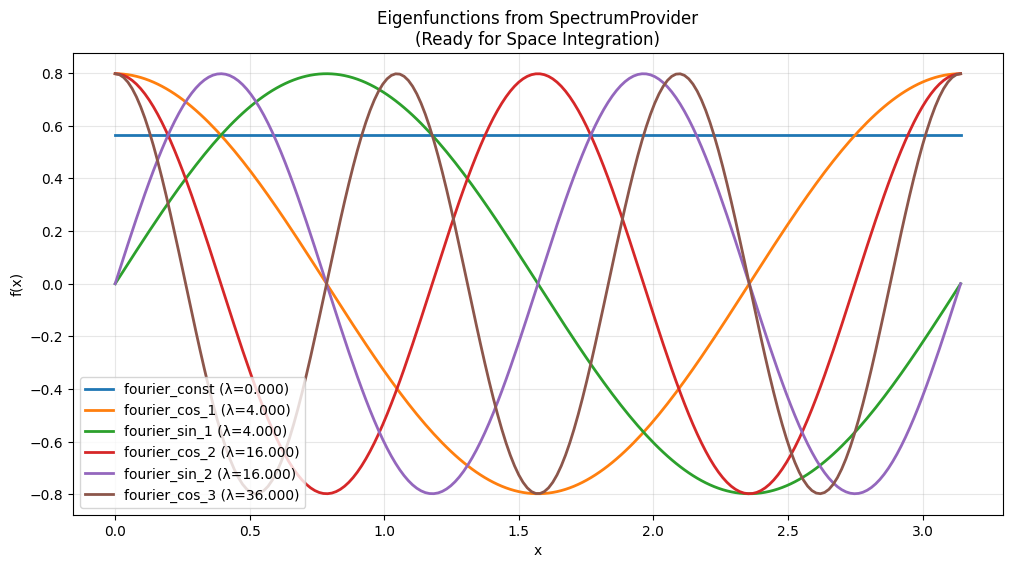


✅ SpectrumProvider provides everything needed for space integration
✅ Ready to replace internal providers in L2Space/SobolevSpace
✅ Enables custom function families + custom operators in spaces


In [10]:
print("=== Integration with Space Classes ===")

# Create spaces that could use our providers
integration_space = L2Space(6, domain, basis_type='fourier')

print(f"🏠 Integration space: {integration_space.dim}D L2Space")
print(f"📐 Domain: {integration_space.function_domain}")

# Create a spectrum provider
fourier_func = FourierFunctionProvider(integration_space)
fourier_eigen = FourierEigenvalueProvider(domain.length)
integration_spectrum = SpectrumProvider(integration_space, fourier_func, fourier_eigen)

print("\n🔗 Created SpectrumProvider for space integration")

# Demonstrate how this could replace the space's internal provider
print("\n🧪 Testing Space Integration Interface:")

# 1. Basis function access (mimics space.get_basis_function)
print("  📈 Basis function access:")
for i in range(3):
    func = integration_spectrum.get_basis_function(i)
    eigenval = integration_spectrum.get_eigenvalue(i)
    print(f"    φ_{i}: {func.name}, λ_{i} = {eigenval:.6f}")

# 2. Bulk operations
all_functions = integration_spectrum.get_all_basis_functions()
all_eigenvalues = integration_spectrum.get_all_eigenvalues()

print(f"\n  📊 Bulk operations:")
print(f"    Functions: {len(all_functions)} basis functions")
print(f"    Eigenvalues: {len(all_eigenvalues)} eigenvalues")
print(f"    Consistent dimensions: {len(all_functions) == len(all_eigenvalues)}")

# 3. Demonstrate computation that would happen in SobolevSpace
print("\n  🔬 Simulated Sobolev Inner Product Computation:")
print("     For SobolevSpace: ⟨f,g⟩_s = Σ (1+λₖ)ˢ f̂ₖ ḡₖ")

s = 1.0  # Sobolev parameter
sobolev_weights = [(1 + eigenval)**s for eigenval in all_eigenvalues]

print(f"     Sobolev weights (s={s}):")
for i, weight in enumerate(sobolev_weights[:5]):
    print(f"       (1+λ_{i})^{s} = {weight:.6f}")

# 4. Visualize the basis functions
x = np.linspace(0, np.pi, 200)
plt.figure(figsize=(12, 6))

for i in range(6):
    func = integration_spectrum.get_eigenfunction(i)
    y = np.array([func.evaluate(xi) for xi in x])
    plt.plot(x, y, linewidth=2, label=f'{func.name} (λ={integration_spectrum.get_eigenvalue(i):.3f})')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Eigenfunctions from SpectrumProvider\n(Ready for Space Integration)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ SpectrumProvider provides everything needed for space integration")
print("✅ Ready to replace internal providers in L2Space/SobolevSpace")
print("✅ Enables custom function families + custom operators in spaces")